# Flopy example 2
building basic modflow6 model from scratch using flopy, some wells, with unstructured grid creation

In [1]:
import flopy
import numpy as np

flopy is installed in C:\thomas\Anaconda3\lib\site-packages\flopy


In [2]:
# set up model
modelname = 'ex2'

# create simulation with modflow6
sim = flopy.mf6.MFSimulation(sim_name='ex2', version='mf6', exe_name='mf6', sim_ws='sim/ex2')
# create model in simulation
mf = flopy.mf6.ModflowGwf(sim, modelname=modelname)

# create the flopy iterative model solver (ims) package object
ims = flopy.mf6.modflow.mfims.ModflowIms(sim)

# create discretization object, time, 1 steady state period of 1 second, transient period of 1 day (or 86400s)
tdis = flopy.mf6.ModflowTdis(sim, time_units='seconds', nper=2, perioddata=[(1.0,10,1.0), (86400.0,24,1.0)]) # period len, period steps, period multiplier

In [3]:
# model domain & grid definition
Lx, Ly = 1000., 1000. # aquifer length in x, y [meters]
ztop = 100.  # aquifer top elevation
nlay, nrow, ncol = 2, 20, 20  # of layer, rows, columns
botm = [80., 60.] # bottom elevation for each layer
delr, delc = Lx/ncol, Ly/nrow # spacing along rows/columns

# create discretization object, spatial
dis = flopy.mf6.ModflowGwfdis(mf, nlay=nlay, nrow=nrow, ncol=ncol, delr=delr, delc=delc, top=ztop, botm=botm, length_units='METERS')

In [4]:
# define hydraulic properties
npf = flopy.mf6.ModflowGwfnpf(mf, icelltype=1, save_flows=True, k=[3.5e-4, 7e-5]) # hydraulic conductivity for each layer

# define initial heads to 99
ic = flopy.mf6.ModflowGwfic(mf, strt=99)

# define dynamic hydraulic parameters, the first layer is convertible and the second layer confined
sto = flopy.mf6.ModflowGwfsto(mf, save_flows=True, iconvert=[1,0], ss=1e-5, sy=0.15, steady_state={0:True}, transient={1:True}) # ss, specific storage, sy, specific yield

In [5]:
# define constant head package
stress_period_data = {0: [[[0, row, 0], 95.1] if row < 10 else [[0, row, 19], 99.1]  for row in range(20)]}
chd = flopy.mf6.ModflowGwfchd(mf, stress_period_data=stress_period_data)

In [6]:
# define the two wells for stress period one & two
stress_period_data = {0: [((0,8,8), -0.020, 'First Well'), ((1, 12, 16), -0.025, 'Second Well')], 1: [((0,8,8), -0.050, 'First Well'), ((1,12,16), -0.040, 'Second Well')]}
wel = flopy.mf6.ModflowGwfwel(mf, stress_period_data=stress_period_data, boundnames=True, save_flows=True)

In [7]:
# setup output control package
printrec_tuple_list = [('HEAD', 'ALL'), ('BUDGET', 'ALL')]
saverec_dict = {0:[('HEAD', 'ALL'), ('BUDGET', 'ALL')],1:[('HEAD', 'ALL'), ('BUDGET', 'ALL')]}
ocPackage = flopy.mf6.ModflowGwfoc(mf,
                                    budget_filerecord=[modelname+'.cbc'],
                                    head_filerecord=[modelname+'.hds'],
                                    saverecord=saverec_dict,
                                    printrecord=printrec_tuple_list)

In [8]:
# write simulation & run simulation
sim.write_simulation()
sim.run_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims_-1...
  writing model ex2...
    writing model name file...
    writing package dis...
    writing package npf...
    writing package ic...
    writing package sto...
    writing package chd_0...
INFORMATION: maxbound in ('gwf6', 'chd', 'dimensions') changed to 20 based on size of stress_period_data
    writing package wel_0...
INFORMATION: maxbound in ('gwf6', 'wel', 'dimensions') changed to 2 based on size of stress_period_data
    writing package oc...
FloPy is using the following  executable to run the model: C:\thomas\modflow\mf6.1.0\bin\mf6.EXE
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.1.0 12/12/2019

   MODFLOW 6 compiled Dec 12 2019 13:30:12 with IFORT compiler (ver. 19.0.5)

This software has been approved for release by the U.S. Geological 
Survey (USGS). 

(True, [])

In [9]:
# return the output keys
keys = sim.simulation_data.mfdata.output_keys()

('ex2', 'CBC', 'STO-SS')
('ex2', 'CBC', 'STO-SY')
('ex2', 'CBC', 'FLOW-JA-FACE')
('ex2', 'CBC', 'WEL')
('ex2', 'HDS', 'HEAD')


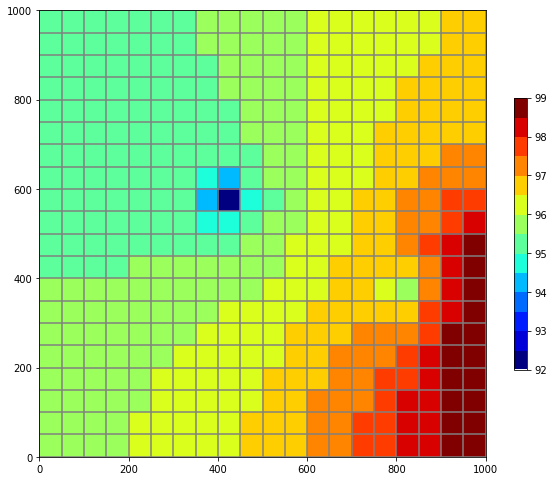

In [10]:
# some plotting
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1,aspect='equal')
# get all head data
head = sim.simulation_data.mfdata['ex2', 'HDS', 'HEAD']
# get the head data from the end of the model run
head_end = head[-1]

# plot the head data from the end of the model run
modelmap = flopy.plot.PlotMapView(model=mf, layer=0)
linecollection = modelmap.plot_grid()
cs = modelmap.plot_array(head_end, vmin=92, vmax=99, cmap=plt.get_cmap('jet', 14))
plt.colorbar(cs, shrink=0.5);

In [11]:
# use gridgen to refine grid around wells
from flopy.utils.gridgen import Gridgen
import os

model_ws = os.path.join('output', 'ex2')
g = Gridgen(dis, model_ws=model_ws, exe_name='C:/thomas/modflow/gridgen.1.0.02/bin/gridgen.exe')

wells = [[Lx / nrow * 8 + 25, Ly / ncol * 8 + 25], [Lx / nrow * 12 + 25, Ly / ncol * 16 + 25]] # x, y cell locations of wells
g.add_refinement_features(wells, 'point', 3, range(nlay))
rf0shp = os.path.join(model_ws, 'rf0')

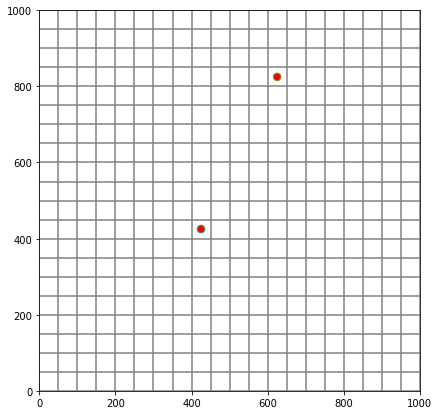

In [12]:
# plot well locations
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
mm = flopy.plot.PlotMapView(model=mf)
mm.plot_grid()
flopy.plot.plot_shapefile(rf0shp, ax=ax, facecolor='red', radius=10);

In [13]:
# build grid
g.build(verbose=False)
g.to_disv6('output/ex2/ex2u.disv6')

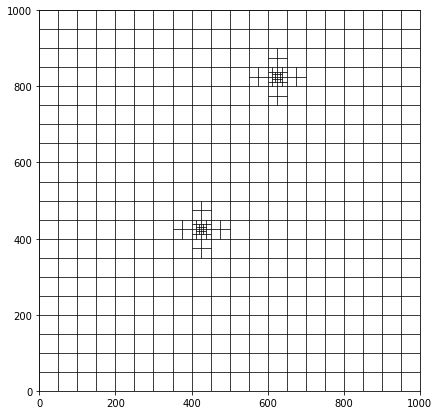

In [14]:
# plot resulting grid
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
g.plot(ax, linewidth=0.5)
flopy.plot.plot_shapefile(rf0shp, ax=ax, facecolor='red', radius=1, alpha=0.2);

In [ ]:
# THIS DOES NOT WORK YET!

# set up model
modelname = 'ex2u'

# create new model in existing simulation
mfu = flopy.mf6.ModflowGwf(sim, modelname=modelname)

# 
disu6 = flopy.mf6.ModflowGwfdisu.load(os.path.join('output', 'ex2', 'ex2u.disv6'), mfu)

# define hydraulic properties
npf = flopy.mf6.ModflowGwfnpf(mfu, icelltype=1, save_flows=True, k=[3.5e-4, 7e-5]) # hydraulic conductivity for each layer

# define initial heads to 99
ic = flopy.mf6.ModflowGwfic(mfu, strt=99)

# define dynamic hydraulic parameters, the first layer is convertible and the second layer confined
sto = flopy.mf6.ModflowGwfsto(mfu, save_flows=True, iconvert=[1,0], ss=1e-5, sy=0.15, steady_state={0:True}, transient={1:True}) # ss, specific storage, sy, specific yield

# define constant head package
stress_period_data = {0: [[[0, row, 0], 95.1] if row < 10 else [[0, row, 19], 99.1]  for row in range(20)]}
chd = flopy.mf6.ModflowGwfchd(mfu, stress_period_data=stress_period_data)

# define the two wells for stress period one & two
stress_period_data = {0: [((0,8,8), -0.020, 'First Well'), ((1, 12, 16), -0.025, 'Second Well')], 1: [((0,8,8), -0.050, 'First Well'), ((1,12,16), -0.040, 'Second Well')]}
wel = flopy.mf6.ModflowGwfwel(mfu, stress_period_data=stress_period_data, boundnames=True, save_flows=True)

# setup output control package
printrec_tuple_list = [('HEAD', 'ALL'), ('BUDGET', 'ALL')]
saverec_dict = {0:[('HEAD', 'ALL'), ('BUDGET', 'ALL')],1:[('HEAD', 'ALL'), ('BUDGET', 'ALL')]}
ocPackage = flopy.mf6.ModflowGwfoc(mfu,
                                    budget_filerecord=[modelname+'.cbc'],
                                    head_filerecord=[modelname+'.hds'],
                                    saverecord=saverec_dict,
                                    printrecord=printrec_tuple_list)

# write simulation & run simulation
sim.write_simulation()
sim.run_simulation()